# Фильтрация и анализ данных из подготовленной таблицы динамики признаков с использованием AE RNN LSTM (версия 2)
-------

**Дано:**
- имеется таблица, фиксирующая изменение всех важных признаков/фичей во времени (фичи генерировались и подбирались на предыдущем этапе);
- индексом таблицы является дата-время либо в виде TimeStamp либо в виде DateTime;
- все фичи закодированы численно либо как one-hot enc (категориальные фичи).

**Требуется:**
- разработать pipeline для эмбеддинга, кодирования окон изменения фичей с использованием AE или VAE;
- разработать функционал визуального анализа структуры кластеров кодов и соответствующих им окон;
- исследовать как архитектура сверточных слоев AE влияет на кодирование окон;
- выявить основные типы окон, которые может кодировать/распознавать/выделять АЭ в зависимости от его архитектуры.

In [ ]:
# подключаем колаб к нашему гугл-диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# устанавливаем рабочую директорию/каталог
import os

path = "/content/drive/My Drive/Colab Notebooks/Moneta/"
os.chdir(path)
# print(os.listdir())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import seaborn as sbn
np.set_printoptions(precision=3)

import datetime as dt
print('Last Updated On: ', dt.datetime.now().date())

import sys

""" параметры графиков """
plt.style.use('ggplot')
plt.rcParams['font.fantasy'] = 'Arial', 'Times New Roman', 'Tahoma', 'Comic Sans MS', 'Courier'

Last Updated On:  2023-02-03


# ПЛАН РАБОТ
---

1. Считываем и делаем визуальный анализ попарных зависимостей данных
1. Выбираем ширину окна. Формируем датасет и даталоадер для обучения и тестирования АЭ.
1. Строим АЭ с выделением энкодера и декодера в отдельную нейросеть
1. Обучаем АЭ
1. Кодируем энкодером окна
1. Кластеризуем окна; выбираем наилучший метод и параметры силуэтным анализом (k-means, )
1. Делаем проекцию tSNE и визуализируем кластерную структуру
1. Проводим анализ получившихся кластеров окон


## **Считываем данные**
---

Подготовленные данные 

datetime|	val_00 | val_01 | ...
--- | --- | --- | ---
01.01.2009|	29,3916 | -0.108 | ...
12.01.2009|	30,5331 | 1.1415 | ...




In [ ]:
prep_df = pd.read_csv('data/dollar_prepared.csv', header=0, sep=';', index_col=0) # 
print(prep_df.shape)
prep_df.tail(5)

(5052, 11)


,dollar,d_dollar,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,sin_month,cos_month
datetime,,,,,,,,,,,
2022-10-27,61.4012,-0.0743,0,0,0,1,0,0,0,-1.0,-1.836970e-16
2022-10-28,61.5294,0.1282,0,0,0,0,1,0,0,-1.0,-1.836970e-16
2022-10-29,61.5294,0.0000,0,0,0,0,0,1,0,-1.0,-1.836970e-16
2022-10-30,61.5294,0.0000,0,0,0,0,0,0,1,-1.0,-1.836970e-16
2022-10-31,61.6277,0.0983,1,0,0,0,0,0,0,-1.0,-1.836970e-16


In [ ]:
import datetime as dt

prep_df.index = pd.to_datetime(prep_df.index)
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5052 entries, 2009-01-01 to 2022-10-31
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar         5052 non-null   float64
 1   d_dollar       5052 non-null   float64
 2   day_of_week_0  5052 non-null   int64  
 3   day_of_week_1  5052 non-null   int64  
 4   day_of_week_2  5052 non-null   int64  
 5   day_of_week_3  5052 non-null   int64  
 6   day_of_week_4  5052 non-null   int64  
 7   day_of_week_5  5052 non-null   int64  
 8   day_of_week_6  5052 non-null   int64  
 9   sin_month      5052 non-null   float64
 10  cos_month      5052 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 473.6 KB


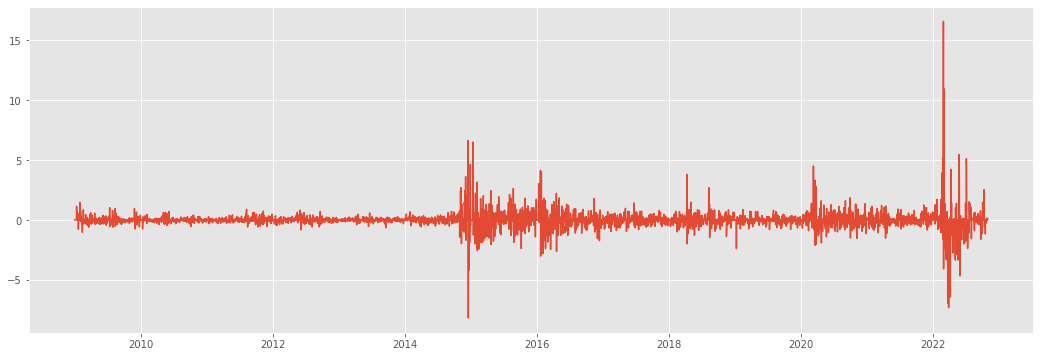

In [ ]:
plt.figure(figsize=(18,6))

plt.plot(prep_df.d_dollar.index, prep_df.d_dollar.values);

## **Визуальный анализ и выбор признаков**
---
Выделим из загруженной таблицы поля, которые будем использовать для анализа

Также выделим временные границы для последующей работы: возможно, нет смысла использовать динамику курса до 2014 года - она была совсем другой. Также мы можем убрать из обучающей выборки данные 2022 года, чтобы посмотреть как будет эмбеддить сеть резкие скачки (аномалии)


In [ ]:
# Устанавливаем границы выбора данных для обучающей и тестовой выборок

train_start = dt.datetime(year=2014, month=1, day=1)
train_end = dt.datetime(year=2022, month=1, day=1)
test_start = train_end
test_end = prep_df.index[-1]

train_cond = prep_df.index <= train_end
train_cond = train_cond & (prep_df.index >= train_start)
test_cond = prep_df.index >= test_start
test_cond = test_cond & (prep_df.index <= test_end)

len(prep_df), sum(train_cond), sum(test_cond)

(5052, 2923, 304)

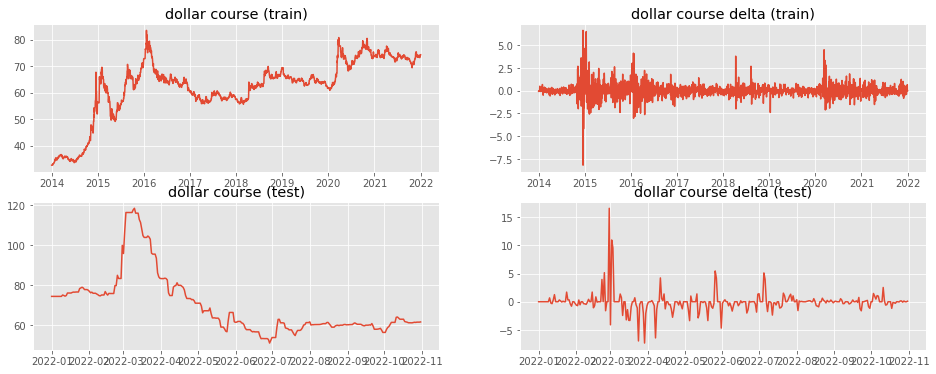

In [ ]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(221)
ax1.plot(prep_df.dollar.loc[train_cond])
ax1.set_title('dollar course (train)')
ax2 = plt.subplot(222)
ax2.plot(prep_df.d_dollar.loc[train_cond])
ax2.set_title('dollar course delta (train)')

ax3 = plt.subplot(223)
ax3.plot(prep_df.dollar.loc[test_cond])
ax3.set_title('dollar course (test)')
ax4 = plt.subplot(224)
ax4.plot(prep_df.d_dollar.loc[test_cond])
ax4.set_title('dollar course delta (test)')

plt.show()

In [ ]:
features = ['dollar', 'd_dollar', 'day_of_week_0', 'day_of_week_5', 'day_of_week_6', 'sin_month']
# sbn.pairplot(prep_df.loc[train_cond, features]);

In [ ]:
# уточняем признаки, с которыми далее будем работать
prep_df.columns
features = ['dollar', 'd_dollar', 'day_of_week_5', 'day_of_week_6', 'sin_month']
# уточняем целевые признаки, которые хотим кодировать/воспроизводить
goal_features = ['dollar', 'd_dollar']
goal_indexes = [features.index(x) for x in goal_features]
print(goal_indexes)

[0, 1]


resume:

- необходимо шкалировать чисто числовые признаки, так как они имеют разный разброс;
- есть статистическая зависимость между сезоном (месяцем) и диапазоном и средним изменений d_dollar;
- видим, что на изменение курса доллара влияет фактор выходного дня;

## **Готовим датасеты**
---
- Выбираем ширину окна win_width и шаг по окну win_step;
- формируем свой класс датасета;
- готовим datasets для обучения и для тестирования

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available(): 
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

### Фильтруем признаки и данные
---
- Выберем после результатов анализа зависимостей признаки, которые оказывают влияние на изменение основной величины (курса доллара); вектора с данными признаками будут подаваться на вход АЭ;

- также укажем конкретно какие признаки мы хотим эмбеддить/кодировать (остальные признаки будут вспомогательными для кодирования); эта информация будет использоваться для обучении АЭ при оценке лосса (будем требовать восстановления только данных целевых признаков);

- оформим все данные в виде отдельной таблицы df и тензора data; его далее мы и будем использовать как источника для формирования последовательностей векторов для обучения автоэнкодера;

In [ ]:
df = prep_df[features]
df.tail(3)

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
datetime,,,,,
2022-10-29,61.5294,0.0000,1,0,-1.0
2022-10-30,61.5294,0.0000,0,1,-1.0
2022-10-31,61.6277,0.0983,0,0,-1.0


### Масштабирование данных
---
- перед применение нейросети необходимо отмасштабировать данные. Это можно сделать сразу или строить pipline непосредственно при обучении/применении нейросети.

- шкалер нам может понадобиться для того, чтобы дешкалировать данные для последующего анализа.

In [ ]:
df.describe()

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,51.370161,0.006381,0.142914,0.142914,4.993958e-03
std,18.079718,0.650414,0.350019,0.350019,7.070891e-01
min,27.262500,-8.182200,0.000000,0.000000,-1.000000e+00
25%,31.568700,-0.094100,0.000000,0.000000,-5.000000e-01
50%,57.558500,0.000000,0.000000,0.000000,1.224647e-16
75%,65.666950,0.085050,0.000000,0.000000,8.660254e-01
max,118.438900,16.569800,1.000000,1.000000,1.000000e+00


Воспользуемся стандартным шкалером для масштабирования самого курса и его колебаний;

- нужно указать какие из признаков мы будем кодировать features_to_scale; в нашем случае набор признаков совпадает с целевыми признаками

- шкалирование производим по обучающей выборке

In [ ]:
from sklearn.preprocessing import StandardScaler

dollar_scaler = StandardScaler()
features_to_scale = goal_features
dollar_scaler.fit(df.loc[train_cond, features_to_scale])

df_norm = df.copy()
df_norm.loc[:, features_to_scale] = dollar_scaler.transform(df.loc[:, features_to_scale])
df_norm.describe()

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,-0.978557,-0.013103,0.142914,0.142914,4.993958e-03
std,1.624655,1.082214,0.350019,0.350019,7.070891e-01
min,-3.144887,-13.637959,0.000000,0.000000,-1.000000e+00
25%,-2.757929,-0.180292,0.000000,0.000000,-5.000000e-01
50%,-0.422468,-0.023720,0.000000,0.000000,1.224647e-16
75%,0.306162,0.117793,0.000000,0.000000,8.660254e-01
max,5.048285,27.546520,1.000000,1.000000,1.000000e+00


In [ ]:
data = torch.tensor(torch.from_numpy(df_norm.values), dtype=torch.float32, device=device)
data.shape

<ipython-input-16-27c5b442a110>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(torch.from_numpy(df_norm.values), dtype=torch.float32, device=device)


torch.Size([5052, 5])

### Выбираем ширину окна win_width, формируем датасет последовательностей
---
данный класс можно будет использовать:
- для разделения на обучющий (до определенной даты) и тестовый (после определенной даты); 
- для оценки точности алгоритма кодирования на всей выборке;

In [ ]:
class TS_Dataset(Dataset):
    """ Формирование датасета с оконными последовательностями показателей
    data - torch-массив значений показателей с изменением времени, 
    data[idx] - набор показателей в момент времени t[idx]
    win_width - ширина окна, здесь - кол-во временных точек измерения
    transform - преобразование, которое необходимо применить к формируемой последовательности данных
    ВЫХОД:
    - для данного idx окно трансформированных показателей - torch массив размером (win_width, *data.shape)
      динамика показателей с момента t[idx] до t[idx + win_width]
    """
    def __init__(self, data:torch.Tensor, win_width:int, transform=None):
        super(TS_Dataset).__init__()
        self.win_width = win_width
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data) - self.win_width + 1

    def __getitem__(self, idx):
        idx = idx % len(self)
        data_seq = self.data[idx : idx + self.win_width]

        if self.transform:
            data_seq = self.transform(data_seq)
        return data_seq, data_seq

In [ ]:
# ширина окна
win_width = 30

all_dataset = TS_Dataset(data, win_width=win_width)
print(len(all_dataset))

5023


### Формируем выборки для обучения и тестирования и соответствующие даталоадеры
---
Применяем два этапа разбиения.
- Этап 1. Выбираем дату, разделяющую всю последовательность на две части - обучающую и тестовую; это полезно для обучения прогнозированию и выявления аномалий.

- Этап 2. Из всех последовательностей выбираем случайно определенный % для обучающей выборки; остальные - в выборку для валидизации. 

Реализуем класс WindowDataset, в который можно передать не только ширину окна, но и метки времени, с которых начинать выбирать последовательности векторов из переданного массива data.

In [ ]:
class WindowDataset(Dataset):
    def __init__(self, data: torch.Tensor, win_width: int, starts: tuple, active_dim: int = 0, transform=None):
        self.win_width = win_width
        self.data = data
        self.transform = transform
        self.dim: int = active_dim
        self.starts = starts
        assert len(starts) <= self.data.size()[self.dim], "кол-во стартовых точек должно быть менььше кол-ва наблюдений N"
        assert 0 <= max(starts) <= self.data.size()[self.dim] - win_width, "индексы стартовых точек должны лежать в интервале [0, N-width]"

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx) -> torch.Tensor:
        data_seq = self.data.index_select(dim=self.dim, index=torch.LongTensor([i for i in range(self.starts[idx], self.starts[idx] + self.win_width)]))
        if self.transform:
            data_seq = self.transform(data_seq)
        return data_seq, data_seq

Сгенерируем метки времени для обучающей и тестовой выборки - как случайно выбранные значения из набора 0, step, 2*step, ...

In [ ]:
def get_window_time_starts(data_len, win_width, win_step=1, prct=0.7):
    """ выбирает стартовые индексы с учетом шага случайно, если  prct < 1.0
    args
    - data_len - общее количество индексов (моментов времени наблюдений);
    - win_width - ширина окна;
    - win_step - шаг, с которым будем брать стартовые индексы;
    - prct - доля отбираемых индексов для основной выборки из всех возможных;
    """
    assert 0 < prct <= 1.0, "доля индексов должна быть 0 < prct <= 1"
    all_indexes = list(range(0, data_len - win_width + 1, win_step))
    if prct < 1.0:
        N = (data_len - win_width) // win_step + 1
        main_indexes = np.random.choice(all_indexes, size=round(prct * N), replace=False)
    else:
        main_indexes = all_indexes

    rest_indexes = list(set(all_indexes).difference(set(main_indexes)))
    
    return main_indexes, rest_indexes

Создадим соответствующие датасеты

In [ ]:
# шаги, с которым будем формировать данные выборки
win_step_1 = 1
win_step_2 = 2

train_indexes, valid_indexes = get_window_time_starts(len(data[train_cond]), win_width, win_step=win_step_1, prct=0.75)
test_indexes, _ = get_window_time_starts(len(data[test_cond]), win_width, win_step=win_step_1, prct=1.0)
len(train_indexes), len(valid_indexes), len(test_indexes)

(2170, 724, 275)

In [ ]:
train_dataset = WindowDataset(data[train_cond], starts=train_indexes, win_width=win_width)
valid_dataset = WindowDataset(data[train_cond], starts=valid_indexes, win_width=win_width)
test_dataset = WindowDataset(data[test_cond], starts=test_indexes, win_width=win_width)
len(train_dataset), len(valid_dataset), len(test_dataset)

(2170, 724, 275)

## **Формируем даталоадеры**
---
- выбираем batch_size
- формируем даталоадеры для обучения 
- программируем обертку для даталоадера, который готовит батч
# - формируем тензор/батч для тестирования

In [ ]:
# выбираем размер пакета для обучения
batch_size = 16

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_seq, _ = next(iter(valid_dl))
print(batch_seq.size())
# batch_seq[0]

torch.Size([16, 30, 5])


- чтобы не было проблем с загрузкой данных на девайс, лучше использовать обвертку для даталоадеров WrappedDataLoader

- При подготовке пакета для обучения/тестирования из даталоадера с текущим датасетом будет выдаваться тензор вида (batch_size, seq_len, features);
- для nn.LSTM обычно меняют местами индексы batch_size, seq_len, т.е. должен на вход поступать тензор вида (seq_len, batch_size, features); мы можем это сделать также в функции preprocess. Но мы можем использовать опцию batch_first=True в LSTM, чтобы не менять индексы.

In [ ]:
def preprocess(x, y):
    # x = torch.permute(x, (1, 0, 2))
    # y = torch.permute(y, (1, 0, 2))
    return x.to(device), y.to(device)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

batch_seq, _ = next(iter(valid_dl))
print(batch_seq.size())

torch.Size([16, 30, 5])


## **Строим АЭ с выделением энкодера в отдельную нейросеть**
---
Создадим RNN - автоэнкодер с ячейкой LSTM который выделяет важные признаки в последовательностях заданной длины заданных векторов фичей.

В этом скрипте мы будем строить АЭ, который работает по следующему принципу:

- энкодер выдает на выходе один вектор размера embedding_dim независимо от кол-ва слоев энкодера и размерности hidden_dim;
- декодер использует входной вектор размерности embedding_dim для того, чтобы сгенерировать входные хиддены на все свои слои; входом 1-й ячейки 1-го слоя декодера является либо 0-й вектор либо вектор состояния на предыдущем шаге; выход 1-й ячейки последнего слоя направляется на вход 2-й ячейки 1-го слоя и т.д.
- также может использоваться режим teacher_forcing с регулируемой вероятностью.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [ ]:
# выбираем размерность скрытого вектора состояния и количество слоев энкодера и декодера
hidden_dim = 32
n_layers = 2

# также определяем размерность эмбеддинга независимо от предыдущих параметров
embedding_dim = hidden_dim * n_layers

### LSTM-Энкодер (Кодировщик последовательностей)
---
Строим энкодер, состоящий из нескольких слоев по следующему принципу:

- энкодер реализуется в несколько слоев с одинаковыми размерностями hidden_dim;
- выход энкодера вне зависимости от кол-ва слоев и hidden_dim имеет размерность embedding_dim


In [ ]:
class Encoder_sequence(nn.Module):

    def __init__(self, n_features, hidden_dim: int = 32, embedding_dim=16, n_layers=2, dropout: float = 0.1):
        super(Encoder_sequence, self).__init__()

        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.LSTM = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            dropout=dropout,
            batch_first=True
        )

        self.linear = nn.Linear(
            in_features=self.n_layers*self.hidden_dim,
            out_features=self.embedding_dim
        )

        self.batch_norm = nn.BatchNorm1d(self.hidden_dim * self.n_layers)

    def __init_hidden__(self, bptt):
        self.hidden = torch.zeros(self.n_layers, bptt, self.hidden_dim)
        self.cell = torch.zeros(self.n_layers, bptt, self.hidden_dim)
        # Weights initialization
        torch.nn.init.xavier_normal_(self.hidden)
        torch.nn.init.xavier_normal_(self.cell)

    def forward(self, input):
        bptt = input.size()[0]
        self.__init_hidden__(bptt)
        outputs, (self.hidden, self.cell) = self.LSTM(input, (self.hidden, self.cell))
        hidden = torch.permute(self.hidden, (1, 0, 2))
        embedding = hidden.reshape((bptt, -1))
        # embedding = self.batch_norm(embedding)
        # embedding = self.linear(embedding)
        return embedding


encoder = Encoder_sequence(
    n_features=len(features), 
    hidden_dim=hidden_dim, 
    embedding_dim=embedding_dim, 
    n_layers=n_layers
    ).to(device)

batch_seq, _ = next(iter(valid_dl))
print(batch_seq.size(), batch_seq[0,0,0].dtype)
encoder

torch.Size([16, 30, 5]) torch.float32


Encoder_sequence(
  (LSTM): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=64, out_features=64, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
code = encoder(batch_seq)
batch_seq.size(), code.size()

(torch.Size([16, 30, 5]), torch.Size([16, 64]))

### LSTM-Декодер (Генератор последовательностей)
---
Строим декодер, состоящий из нескольких слоев по следующему принципу:

- так как генерируется последовательность векторов из одного вектора (code) - эмбеддинга последовательности, то расчет производится итерационно с помощью LSTM, реализующего одну колонку LSTM-декодера;
- декодер использует входной вектор размерности embedding_dim для того, чтобы сгенерировать входные хиддены на все свои слои или на 1-й слой;
- входом 1-й колонки декодера является либо 0-й вектор либо вектор последовательности на предыдущем шаге; 
- выход 1-й колонки направляется на вход 2-й колонки и т.д.
- также может использоваться режим teacher_forcing с регулируемой вероятностью teacher_forcing_p; в этом случае на входы подаются реальные предыдущие значения векторов последовательности.

In [ ]:
class Decoder_to_sequence(nn.Module):
    """  
    ВХОД: 
    - подается батч кодов последовательностей - тензор размерностью (n_layers, batch_size, embedding_dim);
    - батч предыдущих векторов фичей - вход в 1-ю ячейку - тензор размерностью (batch_size, n_features);
    - (опционально) батч таргетной последовательности на выходе декодера (для реализации teacher_forcing);
    ВЫХОД:
    - батч последовательностей фичей - тензор размерностью (batch_size, seq_len, n_features)
    """
    def __init__(self, n_features: int, seq_len: int, embedding_dim: int, hidden_dim: int = 16, n_layers=2, dropout=0.15):
        super(Decoder_to_sequence,self).__init__()
        self.input_size = n_features
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.LSTMcol = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_dim,
            num_layers = self.n_layers,
            dropout = dropout,
        )
        self.linear_input = nn.Linear(embedding_dim, hidden_dim)
        self.linear_output = nn.Linear(hidden_dim, n_features)
        self.batch_norm1 = nn.BatchNorm1d(self.hidden_dim)
        self.cell = None
        self.hidden = None

    def __init_hidden__(self, code):
        batch_size = code.size()[0]
        # cell init
        self.cell = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        torch.nn.init.xavier_normal_(self.cell)
        # hidden init
        self.hidden = code.view(batch_size, self.n_layers, self.hidden_dim)
        self.hidden = torch.permute(self.hidden, (1, 0, 2))
        #self.hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        # self.hidden[0] = self.linear_input(code)

    def forward(self, code, target_seq=None):
        self.__init_hidden__(code)
        # print(self.hidden.size(), last_input.size())
        outputs = []
        x = torch.zeros(1, code.size(0), self.input_size)
        for i in range(self.seq_len):
            # print(i, '<--', x.size(), self.hidden.size(), self.cell.size())
            output, (self.hidden, self.cell) = self.LSTMcol(x, (self.hidden, self.cell))
            output = output.squeeze()
            # output = self.batch_norm1(output)
            output = self.linear_output(output).unsqueeze(0)
            # print(i, '-->', output.size(), self.hidden.size(), self.cell.size())
            if target_seq is None:
                x = output
            else:
                x = target_seq[:, i, :].unsqueeze(0)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=0)
        outputs = torch.permute(outputs, (1, 0, 2))
        return outputs

decoder = Decoder_to_sequence(n_features=len(features), seq_len=win_width, embedding_dim=embedding_dim, hidden_dim=hidden_dim, n_layers=n_layers).to(device)
decoder

Decoder_to_sequence(
  (LSTMcol): LSTM(5, 32, num_layers=2, dropout=0.15)
  (linear_input): Linear(in_features=64, out_features=32, bias=True)
  (linear_output): Linear(in_features=32, out_features=5, bias=True)
  (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
batch_seq.shape, code.shape, batch_seq[:, 0, :].size()

(torch.Size([16, 30, 5]), torch.Size([16, 64]), torch.Size([16, 5]))

In [ ]:
decode = decoder(code, batch_seq)
code.size(), batch_seq[:, -1, :].size(), decode.size()

(torch.Size([16, 64]), torch.Size([16, 5]), torch.Size([16, 30, 5]))

### Автоэнкодер
---

In [ ]:
class RNN_ae(nn.Module):
    def __init__(self, encoder, decoder, teacher_forcing_ratio = 0.05):
        super(RNN_ae, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, x, target_y=None):
        code = self.encoder(x)
        use_teacher_forcing = True if np.random.random() < self.teacher_forcing_ratio else False
        if use_teacher_forcing:
            y = self.decoder(code, target_y)
        else:
            y = self.decoder(code)
        return y

rnn_ae = RNN_ae(encoder, decoder).to(device)
rnn_ae

RNN_ae(
  (encoder): Encoder_sequence(
    (LSTM): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=64, out_features=64, bias=True)
    (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder_to_sequence(
    (LSTMcol): LSTM(5, 32, num_layers=2, dropout=0.15)
    (linear_input): Linear(in_features=64, out_features=32, bias=True)
    (linear_output): Linear(in_features=32, out_features=5, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
batch_seq.shape

torch.Size([16, 30, 5])

In [ ]:
reconstucted_seq = rnn_ae(batch_seq, batch_seq)
reconstucted_seq.size(), batch_seq.size()

(torch.Size([16, 30, 5]), torch.Size([16, 30, 5]))

## **Обучаем АЭ**
---

In [ ]:
def loss_func(y_pred, y_true):
    return F.mse_loss(y_pred[:, :, goal_indexes], y_true[:, :, goal_indexes])

loss_func(batch_seq, reconstucted_seq)

tensor(1.3710, grad_fn=<MseLossBackward0>)

In [ ]:
# Функция обучения нейросети

def train_ae_model(model: nn.Module, train_loader, test_loader, epochs=5, print_step = 1, verbose=False):
    errs = []
    for epoch in range(epochs):
        for xb, yb in train_loader:
            model.train(True)
            pred = model(xb, yb)
            # print(pred.shape, xb.shape)
            loss = loss_func(pred, yb)

            ## --- обратный проход, вычисление градиентов ---
            optimizer.zero_grad() # чтобы не накапливались градиенты
            loss.backward()

            ## --- корректировка весов ---
            optimizer.step()

        if (epoch % print_step == 0) or (epoch == epochs - 1):
            model.eval()
            with torch.no_grad():
                errs1 = []
                for xb, yb in test_loader:
                    y_pred = model(xb)
                    testloss = loss_func(y_pred, yb).cpu().item()
                    errs1.append(testloss)
                meanloss = sum(errs1) / len(errs1)
                errs.append(meanloss)
            if verbose:
                print('epoch=', epoch, '; loss=', meanloss)

    return errs

In [ ]:
err_list = []

In [ ]:
# Создадим оптимизатор
from torch.optim import Adam, RMSprop

optimizer = Adam(rnn_ae.parameters(), lr=0.001)
# optimizer = RMSprop(rnn_ae.parameters(), lr=0.001)

epoch= 0 ; loss= 0.39910506489484204
epoch= 5 ; loss= 0.37136584811884427
epoch= 10 ; loss= 0.3498008098939191
epoch= 15 ; loss= 0.35554840464306914
epoch= 20 ; loss= 0.3870690277089243
epoch= 25 ; loss= 0.3640180583233419
epoch= 30 ; loss= 0.3298696606703427
epoch= 35 ; loss= 0.3407166885293048
epoch= 40 ; loss= 0.4024080572568852
epoch= 45 ; loss= 0.3682086312252542
epoch= 49 ; loss= 0.36688547921569453


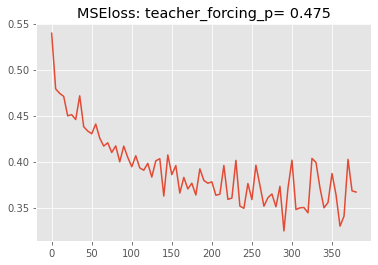

In [ ]:
rnn_ae.teacher_forcing_ratio = 0.5
print_step = 5

for _ in range(1):
    errs = train_ae_model(rnn_ae, train_dl, valid_dl, epochs=50, print_step=print_step, verbose=True)
    err_list += errs
    rnn_ae.teacher_forcing_ratio = rnn_ae.teacher_forcing_ratio * 0.95
    plt.plot(range(0, len(err_list) * print_step, print_step), err_list)
    plt.title(f'MSEloss: teacher_forcing_p= {rnn_ae.teacher_forcing_ratio}')
    plt.show()

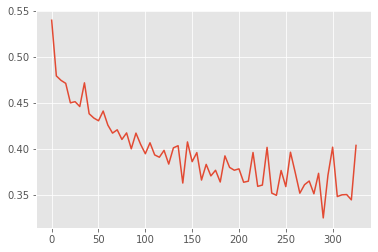

In [ ]:
plt.plot(range(0, len(err_list) * print_step, print_step), err_list);

## **Кластеризуем окна (k-means, agglomerative, ward, DBSCAN, ...)**
---

**Кодируем энкодером последовательности**

In [ ]:
codes = []
with torch.no_grad():
    for idx in range(len(all_dataset)):
        x, _ = all_dataset[idx]
        #x = x.transpose(1, 0)
        x = x.unsqueeze(0)
        # print(x.size(), end='; --> ')
        code = encoder(x)
        # print(code.size())
        codes.append(code.detach().numpy().reshape(1, -1))

all_codes = np.concatenate(codes, axis=0)
all_codes.shape

(5023, 64)

## **Делаем проекцию tSNE и визуализируем структуру кодов**
---

In [ ]:
from sklearn.manifold import TSNE

X = all_codes
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(5023, 2)

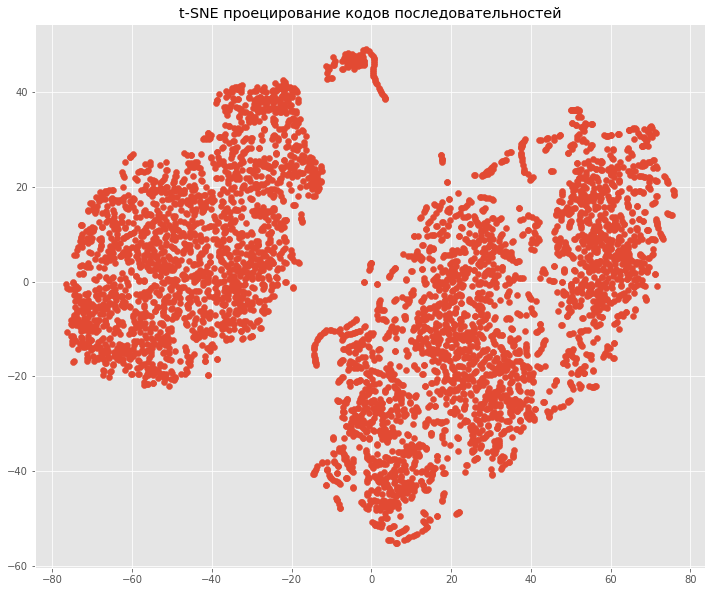

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE проецирование кодов последовательностей');

## Выполним кластеризацию и проанализируем получившуюся структуру кластеров
---

### Метод kmeans++.
---
Определим оптимальное кол-во кластеров

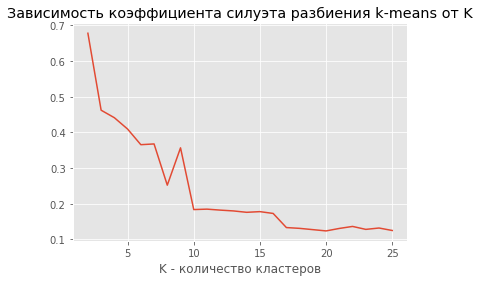

In [ ]:
# Применение k-means
from sklearn.cluster import KMeans
from sklearn import metrics

X = all_codes
k_start = 2
k_end = 25

crit2 = []
for k in range(k_start, k_end + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    crit2.append(metrics.silhouette_score(X, kmeans.labels_))

plt.plot(range(k_start, k_end + 1), crit2)
plt.xlabel('K - количество кластеров')
plt.title('Зависимость коэффициента силуэта разбиения k-means от K');

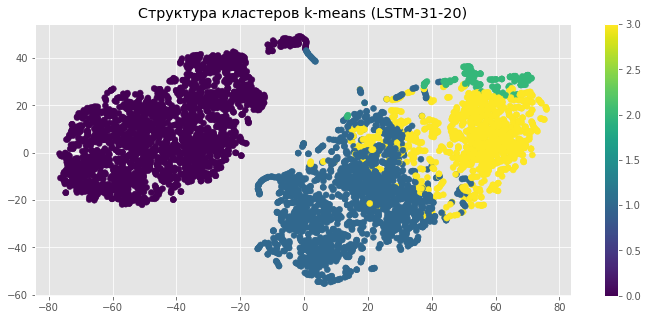

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=123)

# применяем - обучаем
kmeans.fit(X)
# метки кластеров
labels = kmeans.labels_
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.colorbar()
plt.title('Структура кластеров k-means (LSTM-31-20)')
plt.show()

In [ ]:
pd.Series(labels).value_counts()

Проанализируем примеры последовательностей из разных кластеров

In [ ]:
centers_code = torch.tensor(torch.from_numpy(kmeans.cluster_centers_), dtype=torch.float32, device=device)
#centers_code = centers_code.view(centers_code.shape[0], 2, -1)
#centers_code = torch.permute(centers_code, (1, 0, 2))
centers_code.shape

In [ ]:
# так как у нас нет выхода энкодера, то продублируем выход с последнего слоя хиддена
centers_seq = decoder(centers_code)
np_centers_seq = centers_seq.detach().numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels):
        ax[index].plot(range(win_width), np_centers_seq[label, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

In [ ]:
pd.Series(labels).value_counts()

### Метод DBSCAN
---

Этот метод интересен тем, что он может помочь выявить аномалии

In [ ]:
from sklearn.cluster import DBSCAN

X = all_codes

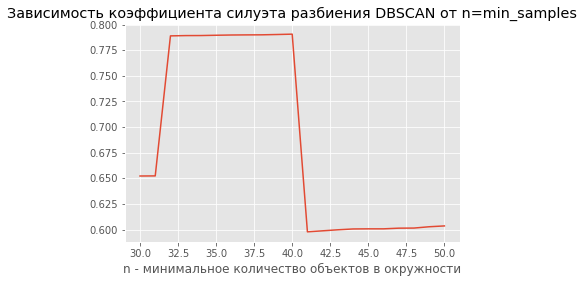

In [ ]:
# применим силуэтный анализ
n_start = 30
n_end = 50
n_step = 1

crit3 = []
for n in range(n_start, n_end + 1, n_step):
    dbscan = DBSCAN(eps=0.8, min_samples=n, metric='euclidean',  algorithm='auto')
    dbscan.fit(X)
    X1 = X[dbscan.labels_ != -1]
    labels_1 = dbscan.labels_[dbscan.labels_ != -1]
    crit3.append(metrics.silhouette_score(X1, labels_1)) # * len(np.unique(labels_1)) * len(X1) / len(X)

plt.plot(range(n_start, n_end + 1, n_step), crit3)
plt.xlabel('n - минимальное количество объектов в окружности')
plt.title('Зависимость коэффициента силуэта разбиения DBSCAN от n=min_samples');

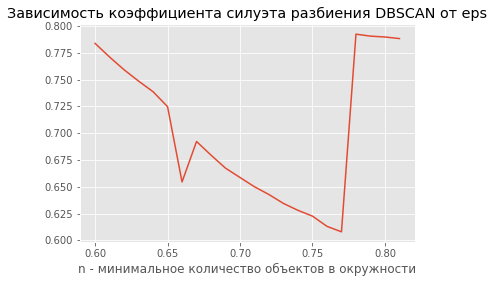

In [ ]:
# применим силуэтный анализ
eps_start = 0.6
eps_end = 0.8
eps_step = 0.01

crit3 = []
for eps in np.arange(eps_start, eps_end + eps_step, eps_step):
    dbscan = DBSCAN(eps=eps, min_samples=35, metric='euclidean',  algorithm='auto')
    dbscan.fit(X)
    X1 = X[dbscan.labels_ != -1]
    labels_1 = dbscan.labels_[dbscan.labels_ != -1]
    # print(eps, end=' ')
    crit3.append(metrics.silhouette_score(X1, labels_1)) #  * len(np.unique(labels_1)) * len(X1) / len(X)

plt.plot(np.arange(eps_start, eps_end + eps_step, eps_step), crit3)
plt.xlabel('n - минимальное количество объектов в окружности')
plt.title('Зависимость коэффициента силуэта разбиения DBSCAN от eps');

выберем значения параметров

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=38, metric='euclidean',  algorithm='auto')
dbscan.fit(X)
labels_1 = dbscan.labels_
pd.Series(labels_1).value_counts()

 0    2045
 1    1575
-1    1403
dtype: int64

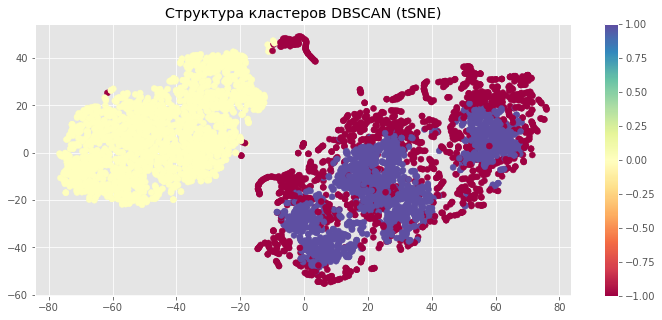

In [ ]:
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_1, cmap=plt.cm.Spectral)
plt.colorbar()
plt.title('Структура кластеров DBSCAN (tSNE)')
plt.show()

проанализируем примеры последовательностей из разных кластеров

In [ ]:
labels_1 = dbscan.labels_[dbscan.labels_ != -1]
cluster_centers = np.array([X[dbscan.labels_ == label].mean(axis=0) for label in range(max(dbscan.labels_)+1)])
centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)
centers_code.shape

<ipython-input-88-e9a7571c16d1>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)


torch.Size([2, 64])

In [ ]:
centers_seq = decoder(centers_code)
np_centers_seq = centers_seq.detach().numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape

(torch.Size([2, 64]), torch.Size([2, 30, 5]), (2, 30, 5))

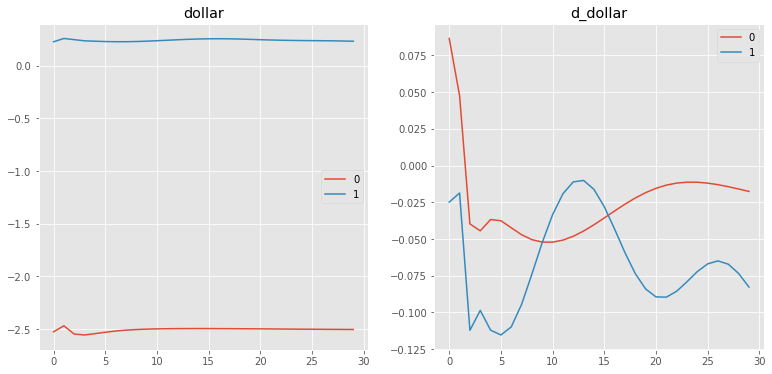

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels_1):
        ax[index].plot(range(win_width), np_centers_seq[label, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

### Иерархическая кластеризация
---

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

X = all_codes

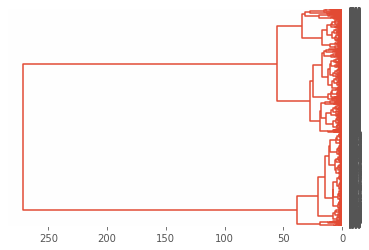

In [ ]:
Z = linkage(X, method='ward', metric='euclidean')

dend = dendrogram(Z, orientation='left', color_threshold=0.0)

In [ ]:
labels_2 = fcluster(Z, 25, criterion='distance')
pd.Series(labels_2).value_counts()

2    2052
5     912
3     731
6     700
4     276
7     117
1     106
9      89
8      40
dtype: int64

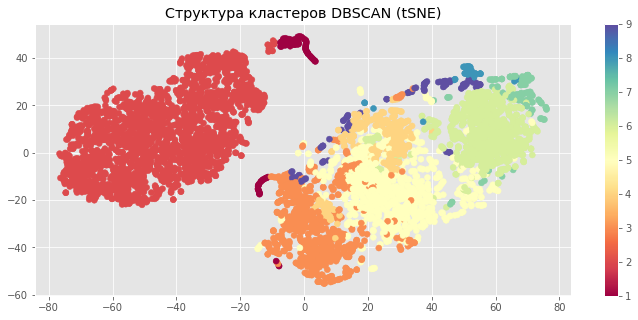

In [ ]:
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_2, cmap=plt.cm.Spectral)
plt.colorbar()
plt.title('Структура кластеров DBSCAN (tSNE)')
plt.show()

проанализируем примеры последовательностей из разных кластеров

In [ ]:
cluster_centers = np.array([X[labels_2 == label].mean(axis=0) for label in set(labels_2)])
centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)
centers_seq = decoder(centers_code)
np_centers_seq = centers_seq.detach().numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape

<ipython-input-98-df307237a3a6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)


(torch.Size([9, 64]), torch.Size([9, 30, 5]), (9, 30, 5))

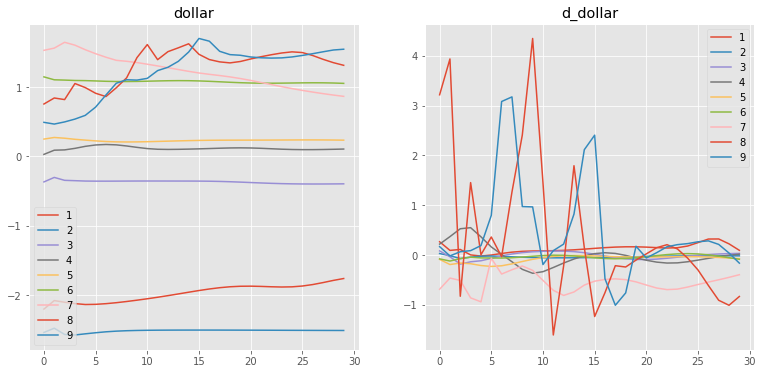

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels_2):
        ax[index].plot(range(win_width), np_centers_seq[label-1, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

### Гауссовская смесь
---

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

X = all_codes

In [ ]:
gm = BayesianGaussianMixture(n_components=9, init_params='kmeans', random_state=0).fit(X)

labels_3 = gm.predict(X)
pd.Series(labels_3).value_counts()

1    2007
0    1343
6     722
2     348
3     251
4     120
8     117
7      73
5      42
dtype: int64

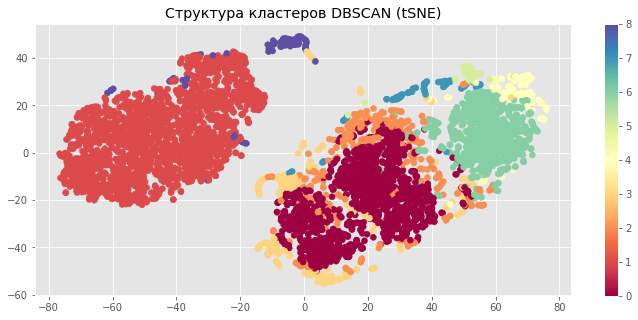

In [ ]:
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_3, cmap=plt.cm.Spectral)
plt.colorbar()
plt.title('Структура кластеров DBSCAN (tSNE)')
plt.show()

In [ ]:
gm.means_

## **Сохранение обученной модели**
------

In [ ]:
model_name = 'lstm_ae2-seq' + str(win_width) + '-ls' + str(hidden_dim)
print(model_name)
torch.save(rnn_ae.state_dict(), path + 'models/' + model_name)

lstm_ae2-seq30-ls32


## черновик 
---------------------

In [ ]:
aaa = torch.Tensor(list(range(24)))
bbb = aaa.reshape(2, 4, 3)
ccc = torch.permute(bbb, (1, 0, 2))
ccc = ccc.reshape(4, -1)
ddd = ccc.view(4, 2, 3)
ddd = ccc.reshape(4, 2, 3)
print(bbb, ccc, ddd, sep='\n')

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]],

        [[12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.]]])
tensor([[ 0.,  1.,  2., 12., 13., 14.],
        [ 3.,  4.,  5., 15., 16., 17.],
        [ 6.,  7.,  8., 18., 19., 20.],
        [ 9., 10., 11., 21., 22., 23.]])
tensor([[[ 0.,  1.,  2.],
         [12., 13., 14.]],

        [[ 3.,  4.,  5.],
         [15., 16., 17.]],

        [[ 6.,  7.,  8.],
         [18., 19., 20.]],

        [[ 9., 10., 11.],
         [21., 22., 23.]]])
